In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data/glove

!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.6B.zip

mkdir: cannot create directory ‘data/glove’: No such file or directory
--2024-11-04 13:44:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-04 13:44:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-04 13:44:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import string
#import keras.backend as K # This import is likely unused, consider removing it

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from keras.preprocessing.text import Tokenizer # Changed import statement
from tensorflow.keras.preprocessing.text import Tokenizer # Import from tensorflow.keras instead
from tensorflow.keras.utils import pad_sequences # Import from tensorflow.keras instead
#from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical # Import from tensorflow.keras instead
#from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense,Conv1D,MaxPooling1D # Import from tensorflow.keras instead
#from keras.layers import Dense,Conv1D,MaxPooling1D
#from keras import models
#from keras import layers
from tensorflow.keras import models # Import from tensorflow.keras instead
from tensorflow.keras import layers # Import from tensorflow.keras instead
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

%matplotlib inline

## **Functions For cleaning Text**

In [7]:
def remove_links(tweet):
    '''Ex:- https://www.google.com.eg/'''
    return re.sub("(http[s]?:\S+)","", tweet)

def remove_shortwords(tweet):
    tweet=re.sub("'", "", tweet)
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if  len(word) > 1]
    return " ".join(clean_tweet)


def remove_mentions(tweet):
    '''@User Mention'''
    return re.sub("@[A-Za-z0-9_]+","", tweet)


def remove_stopwords(tweet):
    stopwords_list = stopwords.words('english')
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if (word not in stopwords_list)]
    return " ".join(clean_tweet)

def remove_nonwords(tweet):
    tweet = re.sub('[^\w]',' ',tweet)
    return tweet

def clean_text(tweet):
    tweet = remove_links(tweet)
    tweet = remove_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_stopwords(tweet)
    tweet = remove_nonwords(tweet)
    tweet = remove_shortwords(tweet)
    tweet = tweet.strip()
    return tweet

**Measurements (recall, precision, fscore)**

In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**Data Reading and Preprocessing**

In [9]:
num_of_words = 32000
max_num_of_words = 50 # in sequence
num_of_dimensions = 300  # For GloVe word embeddings

Data Reading and Cleaning

In [12]:
df = pd.read_csv('/content/drive/MyDrive/chatbot/Original data/file.csv')
df.tweets = df.tweets.apply(clean_text)

Show Majority of tweets

<ipython-input-14-357d44879af0>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  tweets_majority=sns.countplot(data=df, x='labels', palette="viridis")


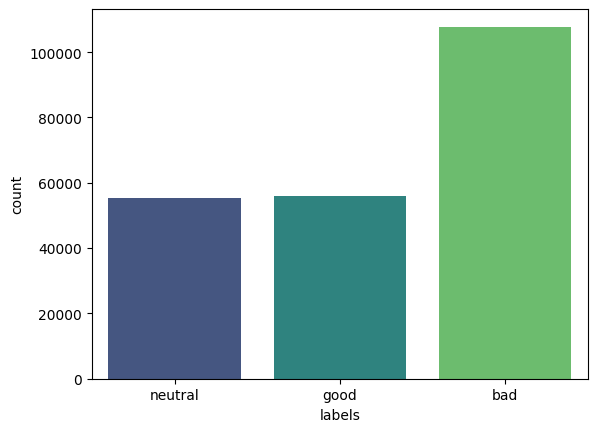

In [14]:
tweets_majority=sns.countplot(data=df, x='labels', palette="viridis")
plt.show()
tweets_majority_fig = tweets_majority.get_figure()
tweets_majority_fig.savefig('/content/drive/MyDrive/chatbot/images/Majority of tweets.png')

Tokenization

In [ ]:
tokenized_tweet = df['tweets'].apply(lambda x: word_tokenize(x))
tokenized_tweet.head()

,tweets
0,"[chatgpt, optimizing, language, models, dialogue]"
1,"[try, talking, chatgpt, new, ai, system, optim..."
2,"[chatgpt, optimizing, language, models, dialog..."
3,"[thrilled, share, chatgpt, new, model, optimiz..."
4,"[minutes, ago, released, new, chatgpt, nand, u..."


Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])
tokenized_tweet.head()

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])

df['tweets'] = tokenized_tweet
df.head()

,Unnamed: 0,tweets,labels
0,0,chatgpt optimizing language model dialogue,neutral
1,1,try talking chatgpt new ai system optimized di...,good
2,2,chatgpt optimizing language model dialogue ai ...,neutral
3,3,thrilled share chatgpt new model optimized dia...,good
4,4,minute ago released new chatgpt nand use right,bad


Splittig the dataset to training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.tweets, df.labels, test_size=0.2, random_state=42)
print(f'# number of training data: {X_train.shape[0]}')
print(f'# number of testing data: {X_test.shape[0]}')

# number of training data: 175435
# number of testing data: 43859


Generating Training and testing Data Files

In [ ]:
training_data=pd.DataFrame({'tweets':X_train[:], 'labels':y_train[:]})
testing_data=pd.DataFrame({'tweets':X_test[:], 'labels':y_test[:]})
training_data.to_csv('/content/drive/MyDrive/chatbot/testing data/testing_data.csv')
testing_data.to_csv('/content/drive/MyDrive/chatbot/training data/training_data.csv')

# **Text Processing**

In [ ]:
tokenizer = Tokenizer(num_words=num_of_words,filters=string.punctuation)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
data_description = X_train.apply(lambda x: len(x.split(' ')))
data_description_df=pd.DataFrame(data_description.describe())
data_description_df

,tweets
count,175435.000000
mean,12.629202
std,7.920655
min,1.000000
25%,6.000000
50%,10.000000
75%,18.000000
max,49.000000


In [ ]:
max_num_of_words=49


X_train = pad_sequences(X_train_sequences, maxlen=max_num_of_words)
X_test = pad_sequences(X_test_sequences, maxlen=max_num_of_words)

print(f'Shape of samples: {X_train.shape}')

Shape of samples: (175435, 49)


Format Output


In [ ]:
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.transform(y_test))
y_test[0]

array([1., 0., 0.])

# **Reading Glove Word Embeddings**

In [ ]:
embedding_dict = {}
glove = open(f'/content/glove.6B.300d.txt', encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = vector
glove.close()

In [ ]:
embedding_matrix = np.zeros((num_of_words, 300))

for w, i in tokenizer.word_index.items():
    if i < num_of_words:
        vect = embedding_dict.get(w)
        if vect is not None:
            embedding_matrix[i] = vect
    else:
        break

print ('Embedding Matrix Shape: ',embedding_matrix.shape)

Embedding Matrix Shape:  (32000, 300)


# **Models Training**

**Fucntion for Plotting The Accuracy and Loss**

In [ ]:
def plotting_model_measurements(history,model_name,trial_num):
    title_name=f'{model_name} Model (Trial-{trial_num})'
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    fig.suptitle(title_name, fontsize=16)
    fig.trial_num=trial_num

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    plt.savefig(f'/content/drive/MyDrive/chatbot/images/{model_name} Model Accuracy and Loss (Trial No.:{trial_num}).png')
    plt.draw()
    plt.tight_layout()

# **Using Convolutional Neural Network(CNN) Architecture**

**Building The Model**

In [ ]:
def build_CNN(Conv1D_1,Conv1D_2,Conv1D_3,_learning_rate,embedding_trainable,model_name):
    model = models.Sequential(name=model_name)
    model.add(layers.Embedding(num_of_words, num_of_dimensions, input_length=max_num_of_words,name='embedding_Layer'))
    if Conv1D_1:
      model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
      model.add(MaxPooling1D(3))

    if Conv1D_2:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))

    if Conv1D_3:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))

    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(3, activation='softmax',name='Output_Layer'))
    model.layers[0].set_weights([embedding_matrix])
    if embedding_trainable:
       model.layers[0].trainable = True
    else:
       model.layers[0].trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate), metrics=['accuracy',f1_m,precision_m, recall_m])
    model.summary()
    return model


cnn_model_trials_dict = {
             'Measurement' : ['Trial-1', 'Trial-2' , 'Trial-3', 'Trial-4', 'Trial-5'], # Trial-1 => 0 , Trial-2 => 1 , ...
             'Training Accuaracy' : [0,0,0,0,0],
             'Testing Accuaracy' : [0,0,0,0,0],
             'Loss' : [0,0,0,0,0],
             'Embedding layer Trainable':['No','No','No','No','No']
}

In [ ]:
def build_CNN(Conv1D_1,Conv1D_2,Conv1D_3,_learning_rate,embedding_trainable,model_name):
    model = models.Sequential(name=model_name)
    # The weights argument is added to initialize the Embedding layer with the pre-trained weights.
    # trainable is set to embedding_trainable to control whether the weights are updated during training.
    model.add(layers.Embedding(num_of_words, num_of_dimensions, weights=[embedding_matrix], input_length=max_num_of_words, trainable=embedding_trainable, name='embedding_Layer'))
    if Conv1D_1:
      model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
      model.add(MaxPooling1D(3))

    if Conv1D_2:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))

    if Conv1D_3:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))

    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(3, activation='softmax',name='Output_Layer'))
    # This line is no longer needed as the weights are initialized during layer creation.
    # model.layers[0].set_weights([embedding_matrix])

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate), metrics=['accuracy',f1_m,precision_m, recall_m])
    model.summary()
    return model

In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import backend as K # Import the Keras backend

In [ ]:
  def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import backend as K # Import the Keras backend

# Updated metric functions to use tf.math.reduce_sum
def precision_m(y_true, y_pred):
    true_positives = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Trial-1 (embedding_trainable=True)

cnn_model_trial1 = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.0001, model_name='CNN_Trial-1')
cnn_model_trial1_history = cnn_model_trial1.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-1'''
tf.keras.utils.plot_model(cnn_model_trial1, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 1).png')

cnn_model_trials_dict['Embedding layer Trainable'][0]='Yes'



# Trial-2 (embedding_trainable=False)

cnn_model_trial2 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.01, model_name='CNN_Trial-2')
cnn_model_trial2_history = cnn_model_trial2.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-2'''
tf.keras.utils.plot_model(cnn_model_trial2, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 2).png')

cnn_model_trials_dict['Embedding layer Trainable'][1]='No'



# Trial-3 (embedding_trainable=False)

cnn_model_trial3 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-3')
cnn_model_trial3_history = cnn_model_trial3.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-3'''
tf.keras.utils.plot_model(cnn_model_trial3, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 3).png')

cnn_model_trials_dict['Embedding layer Trainable'][2]='No'




# Trial-4 (embedding_trainable=True)

cnn_model_trial4 = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-4')
cnn_model_trial4_history = cnn_model_trial4.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-4'''
tf.keras.utils.plot_model(cnn_model_trial4, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 4).png')

cnn_model_trials_dict['Embedding layer Trainable'][3]='Yes'




# Trial-5 (embedding_trainable=False)

cnn_model_trial5 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.0001, model_name='CNN_Trial-5')
cnn_model_trial5_history = cnn_model_trial5.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-5'''
tf.keras.utils.plot_model(cnn_model_trial5, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 5).png')

cnn_model_trials_dict['Embedding layer Trainable'][4]='No'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN_Trial-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 9,600,000 (36.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 915s 2s/step - accuracy: 0.4856 - f1_m: 0.2575 - loss: 1.0143 - precision_m: 0.5589 - recall_m: 0.1939 - val_accuracy: 0.7157 - val_f1_m: 0.6759 - val_loss: 0.6604 - val_precision_m: 0.8025 - val_recall_m: 0.5842
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - accuracy: 0.7269 - f1_m: 0.6984 - loss: 0.6474 - precision_m: 0.7966 - recall_m: 0.6231 - val_accuracy: 0.8092 - val_f1_m: 0.8048 - val_loss: 0.4806 - val_precision_m: 0.8357 - val_recall_m: 0.7762
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 907s 2s/step - accuracy: 0.8160 - f1_m: 0.8080 - loss: 0.4766 - precision_m: 0.8429 - recall_m: 0.7761 - val_accuracy: 0.8507 - val_f1_m: 0.8488 - val_loss: 0.3963 - val_precision_m: 0.8654 - val_recall_m: 0.8329
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 927s 2s/step - accuracy: 0.8625 - f1_m: 0.8596 - loss: 0.3819 - precision_m: 0.8769 - recall_m: 0.8430 - val_accuracy: 0.8716 - val_f1_m: 0.8708 - val_loss: 0.3511 - val_precision_m: 0.8822 - val_recal

Model: "CNN_Trial-2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 516s 936ms/step - accuracy: 0.6229 - f1_m: 0.5586 - loss: 0.8285 - precision_m: 0.7337 - recall_m: 0.4563 - val_accuracy: 0.7237 - val_f1_m: 0.6831 - val_loss: 0.6395 - val_precision_m: 0.8454 - val_recall_m: 0.5736
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 554s 922ms/step - accuracy: 0.7114 - f1_m: 0.6789 - loss: 0.6642 - precision_m: 0.8116 - recall_m: 0.5842 - val_accuracy: 0.7526 - val_f1_m: 0.7103 - val_loss: 0.5950 - val_precision_m: 0.8757 - val_recall_m: 0.5979
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 602s 994ms/step - accuracy: 0.7390 - f1_m: 0.7110 - loss: 0.6114 - precision_m: 0.8279 - recall_m: 0.6237 - val_accuracy: 0.7686 - val_f1_m: 0.7379 - val_loss: 0.5739 - val_precision_m: 0.8593 - val_recall_m: 0.6469
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 543s 960ms/step - accuracy: 0.7535 - f1_m: 0.7285 - loss: 0.5887 - precision_m: 0.8327 - recall_m: 0.6480 - val_accuracy: 0.7675 - val_f1_m: 0.7444 - val_loss: 0.5663 - val_precision_m: 0.8530

Model: "CNN_Trial-3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - accuracy: 0.6485 - f1_m: 0.5635 - loss: 0.7781 - precision_m: 0.7458 - recall_m: 0.4751 - val_accuracy: 0.7808 - val_f1_m: 0.7753 - val_loss: 0.5243 - val_precision_m: 0.8345 - val_recall_m: 0.7242
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 779s 1s/step - accuracy: 0.8183 - f1_m: 0.8121 - loss: 0.4550 - precision_m: 0.8512 - recall_m: 0.7767 - val_accuracy: 0.7972 - val_f1_m: 0.7943 - val_loss: 0.4828 - val_precision_m: 0.8269 - val_recall_m: 0.7644
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - accuracy: 0.8724 - f1_m: 0.8701 - loss: 0.3331 - precision_m: 0.8848 - recall_m: 0.8559 - val_accuracy: 0.8104 - val_f1_m: 0.8084 - val_loss: 0.4691 - val_precision_m: 0.8312 - val_recall_m: 0.7869
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 799s 1s/step - accuracy: 0.9036 - f1_m: 0.9029 - loss: 0.2584 - precision_m: 0.9102 - recall_m: 0.8957 - val_accuracy: 0.7949 - val_f1_m: 0.7945 - val_loss: 0.6254 - val_precision_m: 0.8021 - val_recal

Model: "CNN_Trial-4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 9,600,000 (36.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 1143s 2s/step - accuracy: 0.7196 - f1_m: 0.6638 - loss: 0.6426 - precision_m: 0.7826 - recall_m: 0.5989 - val_accuracy: 0.8977 - val_f1_m: 0.8971 - val_loss: 0.2807 - val_precision_m: 0.9083 - val_recall_m: 0.8863
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 1169s 2s/step - accuracy: 0.9220 - f1_m: 0.9209 - loss: 0.2357 - precision_m: 0.9269 - recall_m: 0.9151 - val_accuracy: 0.9104 - val_f1_m: 0.9102 - val_loss: 0.2526 - val_precision_m: 0.9125 - val_recall_m: 0.9079
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 1141s 2s/step - accuracy: 0.9484 - f1_m: 0.9484 - loss: 0.1582 - precision_m: 0.9511 - recall_m: 0.9458 - val_accuracy: 0.9128 - val_f1_m: 0.9127 - val_loss: 0.2626 - val_precision_m: 0.9150 - val_recall_m: 0.9103
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 1132s 2s/step - accuracy: 0.9647 - f1_m: 0.9643 - loss: 0.1102 - precision_m: 0.9665 - recall_m: 0.9622 - val_accuracy: 0.9098 - val_f1_m: 0.9099 - val_loss: 0.3354 - val_precision_m: 0.9109 - val_r

Model: "CNN_Trial-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 718s 1s/step - accuracy: 0.5589 - f1_m: 0.3458 - loss: 0.9429 - precision_m: 0.5845 - recall_m: 0.2714 - val_accuracy: 0.7105 - val_f1_m: 0.6662 - val_loss: 0.6678 - val_precision_m: 0.8030 - val_recall_m: 0.5696
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 773s 1s/step - accuracy: 0.7259 - f1_m: 0.6955 - loss: 0.6486 - precision_m: 0.8043 - recall_m: 0.6136 - val_accuracy: 0.7675 - val_f1_m: 0.7576 - val_loss: 0.5539 - val_precision_m: 0.8219 - val_recall_m: 0.7028
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 807s 1s/step - accuracy: 0.8072 - f1_m: 0.7956 - loss: 0.4933 - precision_m: 0.8440 - recall_m: 0.7528 - val_accuracy: 0.7873 - val_f1_m: 0.7852 - val_loss: 0.5127 - val_precision_m: 0.8155 - val_recall_m: 0.7573
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 743s 1s/step - accuracy: 0.8634 - f1_m: 0.8591 - loss: 0.3737 - precision_m: 0.8796 - recall_m: 0.8397 - val_accuracy: 0.7935 - val_f1_m: 0.7929 - val_loss: 0.5161 - val_precision_m: 0.8050 - val_recal

In [ ]:
cnn_model_trial5 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.0001, model_name='CNN_Trial-5')
cnn_model_trial5_history = cnn_model_trial5.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-5'''
tf.keras.utils.plot_model(cnn_model_trial5, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 5).png')

cnn_model_trials_dict['Embedding layer Trainable'][4]='No'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN_Trial-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 711s 1s/step - accuracy: 0.5679 - f1_m: 0.3729 - loss: 0.9314 - precision_m: 0.6145 - recall_m: 0.2937 - val_accuracy: 0.7134 - val_f1_m: 0.6838 - val_loss: 0.6624 - val_precision_m: 0.7822 - val_recall_m: 0.6078
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 792s 1s/step - accuracy: 0.7320 - f1_m: 0.7036 - loss: 0.6379 - precision_m: 0.8022 - recall_m: 0.6273 - val_accuracy: 0.7725 - val_f1_m: 0.7631 - val_loss: 0.5455 - val_precision_m: 0.8213 - val_recall_m: 0.7128
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - accuracy: 0.8137 - f1_m: 0.8039 - loss: 0.4784 - precision_m: 0.8456 - recall_m: 0.7664 - val_accuracy: 0.7653 - val_f1_m: 0.7665 - val_loss: 0.5678 - val_precision_m: 0.7924 - val_recall_m: 0.7423
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 756s 1s/step - accuracy: 0.8684 - f1_m: 0.8660 - loss: 0.3613 - precision_m: 0.8819 - recall_m: 0.8508 - val_accuracy: 0.7956 - val_f1_m: 0.7948 - val_loss: 0.5284 - val_precision_m: 0.8036 - val_recal

<Figure size 640x480 with 0 Axes>

In [ ]:
cnn_model_trial1 = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.0001, model_name='CNN_Trial-1')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN_Trial-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 9,600,000 (36.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model_trial2 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.01, model_name='CNN_Trial-2')

Model: "CNN_Trial-2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

In [ ]:
cnn_model_trial3 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-3')

Model: "CNN_Trial-3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

In [ ]:
cnn_model_trial4 = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-4')

Model: "CNN_Trial-4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 9,600,000 (36.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Trial-1
training_score = cnn_model_trial1.evaluate(X_train, y_train)
testing_score = cnn_model_trial1.evaluate(X_test, y_test)

print(f'\nTrial 1')
print(f'Training Accuaracy (Trial 1): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 1): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 1 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][0]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][0]=round(testing_score[1]*100,1)



# Trial-2
training_score = cnn_model_trial2.evaluate(X_train, y_train)
testing_score = cnn_model_trial2.evaluate(X_test, y_test)

print(f'\nTrial 2')
print(f'Training Accuaracy (Trial 2): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 2): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 2 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][1]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][1]=round(testing_score[1]*100,1)




# Trial-3
training_score = cnn_model_trial3.evaluate(X_train, y_train)
testing_score = cnn_model_trial3.evaluate(X_test, y_test)

print(f'\nTrial 3')
print(f'Training Accuaracy (Trial 3): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 3): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 3 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][2]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][2]=round(testing_score[1]*100,1)




# Trial-4
training_score = cnn_model_trial4.evaluate(X_train, y_train)
testing_score = cnn_model_trial4.evaluate(X_test, y_test)

print(f'\nTrial 4')
print(f'Training Accuaracy (Trial 4): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 4): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 4 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][3]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][3]=round(testing_score[1]*100,1)




# Trial-5
training_score = cnn_model_trial5.evaluate(X_train, y_train)
testing_score = cnn_model_trial5.evaluate(X_test, y_test)

print(f'\nTrial 5')
print(f'Training Accuaracy (Trial 5): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 5): {round(testing_score[1]*100,1)}%\n\n')

'''   Save the data of trial 5 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][4]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][4]=round(testing_score[1]*100,1)


cnn_model_trials_df = pd.DataFrame(cnn_model_trials_dict)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 275s 50ms/step - accuracy: 0.2697 - f1_m: 0.0043 - loss: 1.1101 - precision_m: 0.0661 - recall_m: 0.0022
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 70s 51ms/step - accuracy: 0.2698 - f1_m: 0.0034 - loss: 1.1113 - precision_m: 0.0526 - recall_m: 0.0018

Trial 1
Training Accuaracy (Trial 1): 27.0%
Testing Accuaracy (Trial 1): 27.1%
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 271s 49ms/step - accuracy: 0.3027 - f1_m: 6.6973e-04 - loss: 1.1046 - precision_m: 0.0109 - recall_m: 3.4565e-04
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 70s 51ms/step - accuracy: 0.3061 - f1_m: 7.0708e-04 - loss: 1.1037 - precision_m: 0.0117 - recall_m: 3.6459e-04

Trial 2
Training Accuaracy (Trial 2): 30.5%
Testing Accuaracy (Trial 2): 30.6%
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 317s 58ms/step - accuracy: 0.4926 - f1_m: 0.0000e+00 - loss: 1.0915 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 0.4939 - f1_m: 0.0000e+00 - loss: 1.0916 - precision_m: 0.0000e+00 - recall_m

In [ ]:
plotting_model_measurements(cnn_model_trial1_history,'CNN',1)

NameError: name 'cnn_model_trial1_history' is not defined

In [ ]:
cnn_model_trial1_history = cnn_model_trial1.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - accuracy: 0.5300 - f1_m: 0.3550 - loss: 0.9704 - precision_m: 0.6071 - recall_m: 0.2687 - val_accuracy: 0.7269 - val_f1_m: 0.6967 - val_loss: 0.6348 - val_precision_m: 0.7991 - val_recall_m: 0.6179
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - accuracy: 0.7375 - f1_m: 0.7159 - loss: 0.6215 - precision_m: 0.7983 - recall_m: 0.6498 - val_accuracy: 0.8158 - val_f1_m: 0.8103 - val_loss: 0.4688 - val_precision_m: 0.8428 - val_recall_m: 0.7803
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 876s 2s/step - accuracy: 0.8200 - f1_m: 0.8127 - loss: 0.4651 - precision_m: 0.8449 - recall_m: 0.7832 - val_accuracy: 0.8509 - val_f1_m: 0.8496 - val_loss: 0.3942 - val_precision_m: 0.8634 - val_recall_m: 0.8363
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - accuracy: 0.8669 - f1_m: 0.8638 - loss: 0.3720 - precision_m: 0.8800 - recall_m: 0.8484 - val_accuracy: 0.8711 - val_f1_m: 0.8714 - val_loss: 0.3538 - val_precision_m: 0.8762 - val_recal

In [ ]:
tf.keras.utils.plot_model(cnn_model_trial1, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 1).png')

cnn_model_trials_dict['Embedding layer Trainable'][0]='Yes'

<Figure size 640x480 with 0 Axes>

In [ ]:
# Trial-1
training_score = cnn_model_trial1.evaluate(X_train, y_train)
testing_score = cnn_model_trial1.evaluate(X_test, y_test)

print(f'\nTrial 1')
print(f'Training Accuaracy (Trial 1): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 1): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 1 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][0]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][0]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 272s 50ms/step - accuracy: 0.9735 - f1_m: 0.9736 - loss: 0.1025 - precision_m: 0.9745 - recall_m: 0.9727
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 65s 48ms/step - accuracy: 0.8967 - f1_m: 0.8966 - loss: 0.3313 - precision_m: 0.8978 - recall_m: 0.8953

Trial 1
Training Accuaracy (Trial 1): 95.9%
Testing Accuaracy (Trial 1): 89.6%


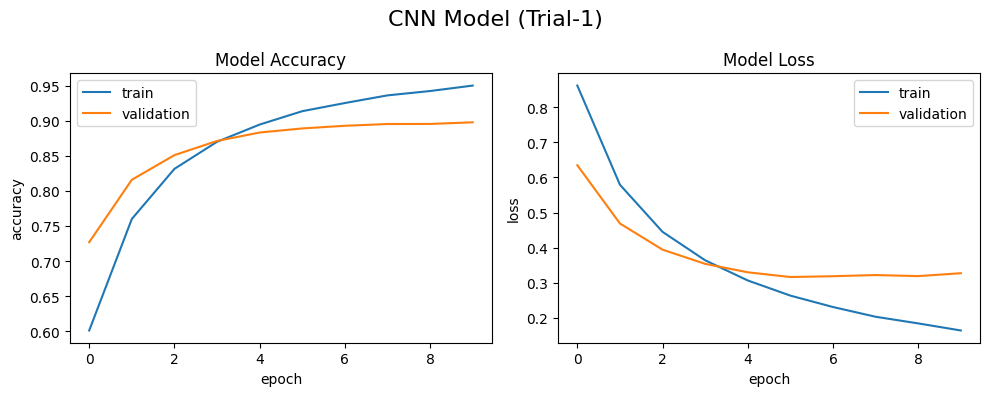

In [ ]:
plotting_model_measurements(cnn_model_trial1_history,'CNN',1)

In [ ]:
cnn_model_trial1.save('/content/drive/MyDrive/chatbot/saved model/cnn/CNN_model_trial1_Saved.keras') # Add the .keras extension to the filepath

In [ ]:
training_score = cnn_model_trial5.evaluate(X_train, y_train)
testing_score = cnn_model_trial5.evaluate(X_test, y_test)

print(f'\nTrial 5')
print(f'Training Accuaracy (Trial 5): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 5): {round(testing_score[1]*100,1)}%\n\n')

'''   Save the data of trial 5 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][4]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][4]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 314s 57ms/step - accuracy: 0.9787 - f1_m: 0.9787 - loss: 0.0821 - precision_m: 0.9789 - recall_m: 0.9785
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 80s 58ms/step - accuracy: 0.7891 - f1_m: 0.7888 - loss: 0.8795 - precision_m: 0.7895 - recall_m: 0.7882

Trial 5
Training Accuaracy (Trial 5): 94.5%
Testing Accuaracy (Trial 5): 78.8%




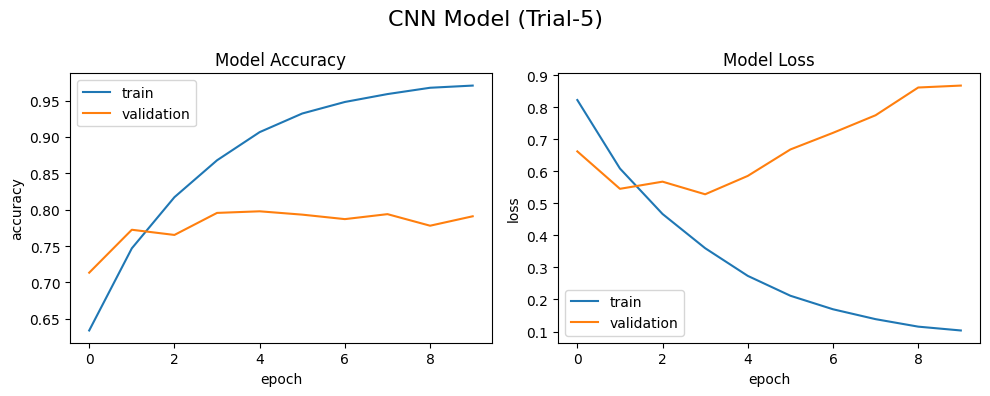

In [ ]:
plotting_model_measurements(cnn_model_trial5_history,'CNN',5)

In [ ]:
cnn_model_trial5.save('/content/drive/MyDrive/chatbot/saved model/cnn/CNN_model_trial5_Saved.keras')


In [ ]:
# Trial-2 (embedding_trainable=False)

cnn_model_trial2 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.01, model_name='CNN_Trial-2')
cnn_model_trial2_history = cnn_model_trial2.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-2'''
tf.keras.utils.plot_model(cnn_model_trial2, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/CNN Model (Trial 2).png')

cnn_model_trials_dict['Embedding layer Trainable'][1]='No'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN_Trial-2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 525s 950ms/step - accuracy: 0.6055 - f1_m: 0.5200 - loss: 0.8614 - precision_m: 0.7138 - recall_m: 0.4206 - val_accuracy: 0.7262 - val_f1_m: 0.6872 - val_loss: 0.6397 - val_precision_m: 0.8352 - val_recall_m: 0.5841
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 525s 955ms/step - accuracy: 0.7068 - f1_m: 0.6727 - loss: 0.6753 - precision_m: 0.8072 - recall_m: 0.5774 - val_accuracy: 0.7464 - val_f1_m: 0.7165 - val_loss: 0.5911 - val_precision_m: 0.8472 - val_recall_m: 0.6211
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 546s 995ms/step - accuracy: 0.7355 - f1_m: 0.7068 - loss: 0.6230 - precision_m: 0.8277 - recall_m: 0.6174 - val_accuracy: 0.7651 - val_f1_m: 0.7352 - val_loss: 0.5621 - val_precision_m: 0.8582 - val_recall_m: 0.6434
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 501s 884ms/step - accuracy: 0.7475 - f1_m: 0.7240 - loss: 0.5958 - precision_m: 0.8341 - recall_m: 0.6400 - val_accuracy: 0.7708 - val_f1_m: 0.7473 - val_loss: 0.5510 - val_precision_m: 0.8526

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/CNN Model (Trial 2).png'

<Figure size 640x480 with 0 Axes>

In [ ]:
tf.keras.utils.plot_model(cnn_model_trial2, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 2).png')

cnn_model_trials_dict['Embedding layer Trainable'][1]='No'

<Figure size 640x480 with 0 Axes>

In [ ]:
# Trial-2
training_score = cnn_model_trial2.evaluate(X_train, y_train)
testing_score = cnn_model_trial2.evaluate(X_test, y_test)

print(f'\nTrial 2')
print(f'Training Accuaracy (Trial 2): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 2): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 2 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][1]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][1]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 278s 51ms/step - accuracy: 0.8449 - f1_m: 0.8229 - loss: 0.4017 - precision_m: 0.8963 - recall_m: 0.7627
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 67s 49ms/step - accuracy: 0.7803 - f1_m: 0.7601 - loss: 0.5428 - precision_m: 0.8356 - recall_m: 0.6992

Trial 2
Training Accuaracy (Trial 2): 83.5%
Testing Accuaracy (Trial 2): 78.0%


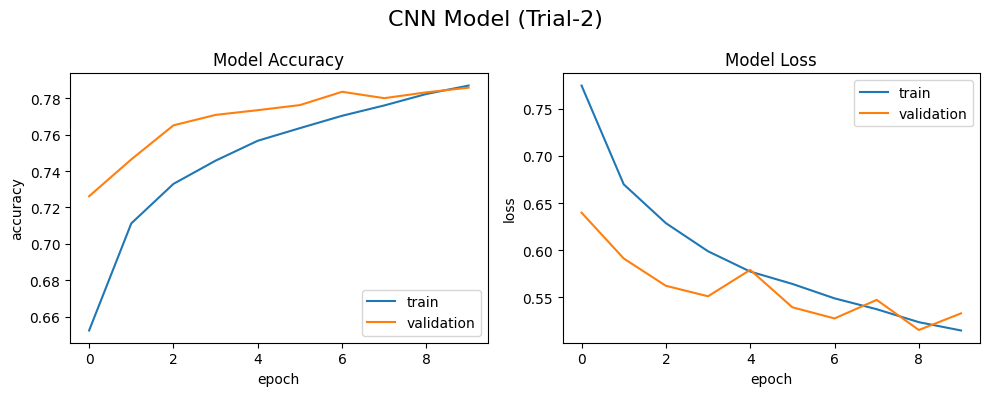

In [ ]:
plotting_model_measurements(cnn_model_trial2_history,'CNN',2)

In [ ]:
cnn_model_trial2.save('/content/drive/MyDrive/chatbot/saved model/cnn/CNN_model_trial2_Saved.keras')

In [ ]:
cnn_model_trial3 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-3')
cnn_model_trial3_history = cnn_model_trial3.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-3'''
tf.keras.utils.plot_model(cnn_model_trial3, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 3).png')

cnn_model_trials_dict['Embedding layer Trainable'][2]='No'

Model: "CNN_Trial-3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 737s 1s/step - accuracy: 0.6549 - f1_m: 0.5798 - loss: 0.7681 - precision_m: 0.7342 - recall_m: 0.4910 - val_accuracy: 0.7912 - val_f1_m: 0.7824 - val_loss: 0.5121 - val_precision_m: 0.8390 - val_recall_m: 0.7332
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 757s 1s/step - accuracy: 0.8235 - f1_m: 0.8171 - loss: 0.4479 - precision_m: 0.8567 - recall_m: 0.7813 - val_accuracy: 0.8082 - val_f1_m: 0.8051 - val_loss: 0.4643 - val_precision_m: 0.8447 - val_recall_m: 0.7691
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 796s 1s/step - accuracy: 0.8731 - f1_m: 0.8707 - loss: 0.3320 - precision_m: 0.8877 - recall_m: 0.8545 - val_accuracy: 0.7942 - val_f1_m: 0.7933 - val_loss: 0.5224 - val_precision_m: 0.8094 - val_recall_m: 0.7778
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 769s 1s/step - accuracy: 0.9084 - f1_m: 0.9075 - loss: 0.2479 - precision_m: 0.9148 - recall_m: 0.9003 - val_accuracy: 0.8121 - val_f1_m: 0.8114 - val_loss: 0.5244 - val_precision_m: 0.8223 - val_recal

<Figure size 640x480 with 0 Axes>

In [ ]:
# Trial-3
training_score = cnn_model_trial3.evaluate(X_train, y_train)
testing_score = cnn_model_trial3.evaluate(X_test, y_test)

print(f'\nTrial 3')
print(f'Training Accuaracy (Trial 3): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 3): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 3 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][2]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][2]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 310s 57ms/step - accuracy: 0.9758 - f1_m: 0.9759 - loss: 0.0811 - precision_m: 0.9762 - recall_m: 0.9756
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 0.8051 - f1_m: 0.8051 - loss: 0.9538 - precision_m: 0.8058 - recall_m: 0.8045

Trial 3
Training Accuaracy (Trial 3): 94.4%
Testing Accuaracy (Trial 3): 80.3%


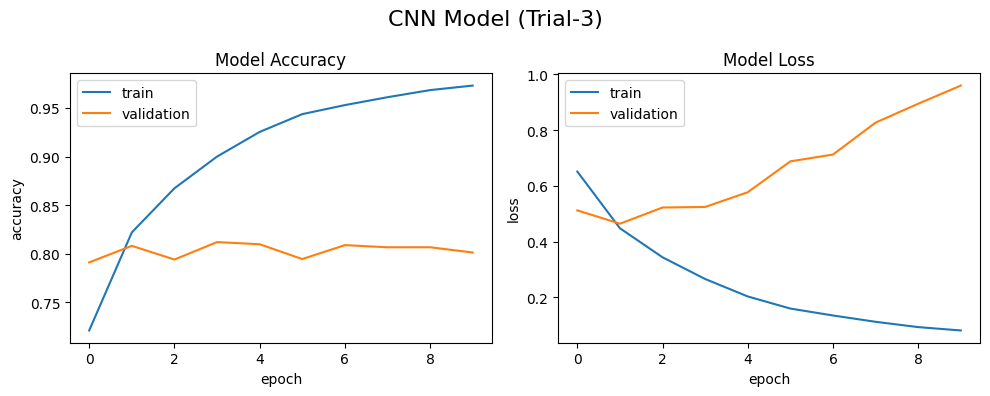

In [ ]:
plotting_model_measurements(cnn_model_trial3_history,'CNN',3)

In [ ]:
cnn_model_trial3.save('/content/drive/MyDrive/chatbot/saved model/cnn/CNN_model_trial3_Saved.keras')

In [ ]:
# Trial-4 (embedding_trainable=True)

cnn_model_trial4 = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-4')
cnn_model_trial4_history = cnn_model_trial4.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-4'''
tf.keras.utils.plot_model(cnn_model_trial4, show_shapes=True)
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (Trial 4).png')

cnn_model_trials_dict['Embedding layer Trainable'][3]='Yes'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN_Trial-4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 9,600,000 (36.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 1139s 2s/step - accuracy: 0.7100 - f1_m: 0.6416 - loss: 0.6612 - precision_m: 0.7701 - recall_m: 0.5756 - val_accuracy: 0.8916 - val_f1_m: 0.8910 - val_loss: 0.2944 - val_precision_m: 0.8997 - val_recall_m: 0.8824
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 1173s 2s/step - accuracy: 0.9203 - f1_m: 0.9196 - loss: 0.2380 - precision_m: 0.9265 - recall_m: 0.9128 - val_accuracy: 0.9088 - val_f1_m: 0.9087 - val_loss: 0.2506 - val_precision_m: 0.9151 - val_recall_m: 0.9024
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 1133s 2s/step - accuracy: 0.9494 - f1_m: 0.9497 - loss: 0.1565 - precision_m: 0.9531 - recall_m: 0.9464 - val_accuracy: 0.9118 - val_f1_m: 0.9118 - val_loss: 0.2631 - val_precision_m: 0.9142 - val_recall_m: 0.9095
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 1122s 2s/step - accuracy: 0.9655 - f1_m: 0.9654 - loss: 0.1085 - precision_m: 0.9673 - recall_m: 0.9635 - val_accuracy: 0.9131 - val_f1_m: 0.9130 - val_loss: 0.2990 - val_precision_m: 0.9150 - val_r

<Figure size 640x480 with 0 Axes>

In [ ]:
# Trial-4
training_score = cnn_model_trial4.evaluate(X_train, y_train)
testing_score = cnn_model_trial4.evaluate(X_test, y_test)

print(f'\nTrial 4')
print(f'Training Accuaracy (Trial 4): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 4): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 4 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][3]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][3]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 337s 61ms/step - accuracy: 0.9937 - f1_m: 0.9937 - loss: 0.0267 - precision_m: 0.9939 - recall_m: 0.9936
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9081 - f1_m: 0.9081 - loss: 0.5765 - precision_m: 0.9087 - recall_m: 0.9075

Trial 4
Training Accuaracy (Trial 4): 97.8%
Testing Accuaracy (Trial 4): 90.7%


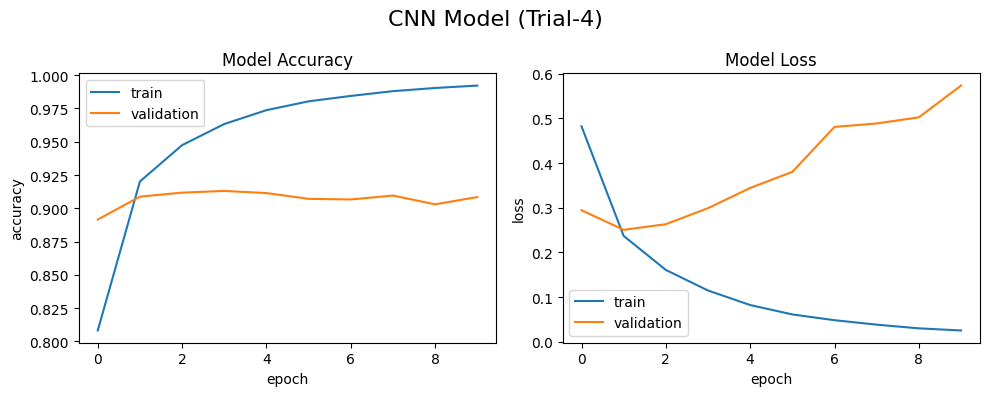

In [ ]:
plotting_model_measurements(cnn_model_trial4_history,'CNN',4)

In [ ]:
cnn_model_trial4.save('/content/drive/MyDrive/chatbot/saved model/cnn/CNN_model_trial4_Saved.keras')

In [ ]:
cnn_model_trials_df = pd.DataFrame(cnn_model_trials_dict)

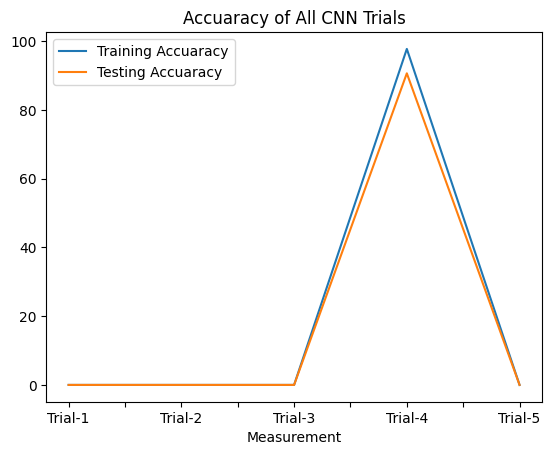

In [ ]:
cnn_model_trials_df[['Measurement','Training Accuaracy','Testing Accuaracy']].plot(x='Measurement', title = 'Accuaracy of All CNN Trials');
plt.savefig('/content/drive/MyDrive/chatbot/images/CNN Model (All Trials Accuracies).png')

In [ ]:
cnn_model_trials_df = pd.DataFrame(cnn_model_trials_dict)
cnn_model_trials_df.to_csv('/content/drive/MyDrive/chatbot/files/CNN_Trials_Table.csv')
cnn_model_trials_df

,Measurement,Training Accuaracy,Testing Accuaracy,Loss,Embedding layer Trainable
0,Trial-1,0.0,0.0,0,No
1,Trial-2,0.0,0.0,0,No
2,Trial-3,0.0,0.0,0,No
3,Trial-4,97.8,90.7,0,Yes
4,Trial-5,0.0,0.0,0,No


# **Long Short Term Memory (LSTM) Architecture**

**Building The Model**

In [ ]:
def build_LSTM(Conv1D,Dense1,Dense2,lstm_units,_learning_rate,embedding_trainable,optimizer_type,model_name):
    model = models.Sequential(name=model_name)
    # set the 'trainable' argument during layer creation
    model.add(layers.Embedding(num_of_words, num_of_dimensions, input_length=max_num_of_words,name='embedding_Layer', trainable=embedding_trainable, weights=[embedding_matrix] if not embedding_trainable else None))
    if Conv1D:
      model.add(layers.Conv1D(64, 8, activation = 'relu'))

    model.add(layers.Bidirectional(layers.LSTM(lstm_units, dropout = 0.2, recurrent_dropout = 0.2)))

    if Dense1:
      model.add(layers.Dense(256, activation='relu'))
      model.add(layers.Dropout(0.5))

    if Dense2:
      model.add(layers.Dense(64, activation='relu'))
      model.add(layers.Dropout(0.5))

    model.add(layers.Dense(3, activation='softmax',name='Output_Layer'))
    # remove the line below as the weights are set during layer creation
    # model.layers[0].set_weights([embedding_matrix])
    # remove the following block, as 'trainable' is already set
    # if embedding_trainable:
    #    model.layers[0].trainable = True
    # else:
    #    model.layers[0].trainable = False

    if optimizer_type=='adam':
      model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),metrics=['accuracy',f1_m,precision_m, recall_m])
    else:
      model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.RMSprop(learning_rate=_learning_rate),metrics=['accuracy',f1_m,precision_m, recall_m])

    model.summary()
    return model
lstm_model_trials_dict = {
             'Measurement' : ['Trial-1', 'Trial-2' , 'Trial-3', 'Trial-4', 'Trial-5'], # Trial-1 => 0 , Trial-2 => 1 , ...
             'Training Accuaracy' : [0,0,0,0,0],
             'Testing Accuaracy' : [0,0,0,0,0],
             'Loss' : [0,0,0,0,0],
             'Embedding layer Trainable':['No','No','No','No','No']
}

In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import backend as K # Import the Keras backend

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import backend as K # Import the Keras backend

# Updated metric functions to use tf.math.reduce_sum
def precision_m(y_true, y_pred):
    true_positives = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Trial-1 (embedding_trainable=True)

lstm_model_trial1 = build_LSTM(Conv1D=False , Dense1=False , Dense2=True , lstm_units=64 , _learning_rate=0.01 , embedding_trainable=True , optimizer_type='adam' , model_name='LSTM_Trial-1')
lstm_model_trial1_history = lstm_model_trial1.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-1'''
tf.keras.utils.plot_model(lstm_model_trial1, show_shapes=True,to_file="/content/drive/MyDrive/chatbot/images/LSTM Model (Trial 1).png")

lstm_model_trials_dict['Embedding layer Trainable'][0]='Yes'

Model: "LSTM_Trial-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 473s 845ms/step - accuracy: 0.7781 - f1_m: 0.7516 - loss: 0.5395 - precision_m: 0.8188 - recall_m: 0.7054 - val_accuracy: 0.9086 - val_f1_m: 0.9058 - val_loss: 0.2581 - val_precision_m: 0.9204 - val_recall_m: 0.8918
Epoch 2/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 494s 831ms/step - accuracy: 0.9233 - f1_m: 0.9223 - loss: 0.2245 - precision_m: 0.9322 - recall_m: 0.9126 - val_accuracy: 0.9072 - val_f1_m: 0.9065 - val_loss: 0.2622 - val_precision_m: 0.9121 - val_recall_m: 0.9010
Epoch 3/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 466s 849ms/step - accuracy: 0.9408 - f1_m: 0.9402 - loss: 0.1807 - precision_m: 0.9453 - recall_m: 0.9353 - val_accuracy: 0.9072 - val_f1_m: 0.9071 - val_loss: 0.2802 - val_precision_m: 0.9105 - val_recall_m: 0.9038
Epoch 4/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 480s 809ms/step - accuracy: 0.9428 - f1_m: 0.9427 - loss: 0.1687 - precision_m: 0.9467 - recall_m: 0.9387 - val_accuracy: 0.9053 - val_f1_m: 0.9056 - val_loss: 0.2964 - val_precision_m: 0.9098 - v

In [ ]:
# Trial-1
training_score = lstm_model_trial1.evaluate(X_train, y_train)
testing_score = lstm_model_trial1.evaluate(X_test, y_test)

print(f'\nTrial 1')
print(f'Training Accuaracy (Trial 1): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 1): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 1 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][0]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][0]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 328s 60ms/step - accuracy: 0.9634 - f1_m: 0.9634 - loss: 0.1113 - precision_m: 0.9670 - recall_m: 0.9600
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - accuracy: 0.9044 - f1_m: 0.9046 - loss: 0.3194 - precision_m: 0.9102 - recall_m: 0.8993

Trial 1
Training Accuaracy (Trial 1): 95.2%
Testing Accuaracy (Trial 1): 90.4%


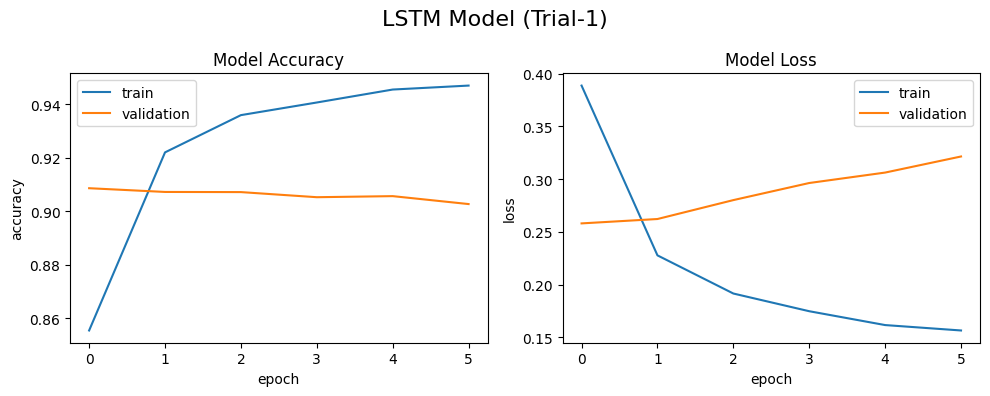

In [ ]:
plotting_model_measurements(lstm_model_trial1_history,'LSTM',1)

In [ ]:
lstm_model_trial1.save('/content/drive/MyDrive/chatbot/saved model/lstm/LSTM_model_trial1_Saved.keras')


In [ ]:
# Trial-2 (embedding_trainable=False)

lstm_model_trial2 = build_LSTM(Conv1D=True , Dense1=False , Dense2=False , lstm_units=512 , _learning_rate=0.001 , embedding_trainable=False , optimizer_type='adam' , model_name='LSTM_Trial-2')
lstm_model_trial2_history = lstm_model_trial2.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-2'''
tf.keras.utils.plot_model(lstm_model_trial2, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/LSTM Model (Trial 2).png")

lstm_model_trials_dict['Embedding layer Trainable'][1]='No'

Model: "LSTM_Trial-2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

Epoch 1/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 3204s 6s/step - accuracy: 0.6552 - f1_m: 0.5983 - loss: 0.7658 - precision_m: 0.7285 - recall_m: 0.5180 - val_accuracy: 0.7882 - val_f1_m: 0.7829 - val_loss: 0.5147 - val_precision_m: 0.8284 - val_recall_m: 0.7422
Epoch 2/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 3136s 6s/step - accuracy: 0.7923 - f1_m: 0.7876 - loss: 0.5041 - precision_m: 0.8300 - recall_m: 0.7494 - val_accuracy: 0.8133 - val_f1_m: 0.8097 - val_loss: 0.4587 - val_precision_m: 0.8500 - val_recall_m: 0.7732
Epoch 3/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 3179s 6s/step - accuracy: 0.8313 - f1_m: 0.8291 - loss: 0.4203 - precision_m: 0.8579 - recall_m: 0.8023 - val_accuracy: 0.8313 - val_f1_m: 0.8305 - val_loss: 0.4220 - val_precision_m: 0.8562 - val_recall_m: 0.8065
Epoch 4/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 3215s 6s/step - accuracy: 0.8579 - f1_m: 0.8554 - loss: 0.3662 - precision_m: 0.8763 - recall_m: 0.8356 - val_accuracy: 0.8402 - val_f1_m: 0.8401 - val_loss: 0.4055 - val_precision_m: 0.8577 - val_recal

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/LSTM Model (Trial 2).png'

In [ ]:
tf.keras.utils.plot_model(lstm_model_trial2, show_shapes=True,to_file="/content/drive/MyDrive/chatbot/images/LSTM Model (Trial 2).png")

lstm_model_trials_dict['Embedding layer Trainable'][1]='No'

In [ ]:
# Trial-2
training_score = lstm_model_trial2.evaluate(X_train, y_train)
testing_score = lstm_model_trial2.evaluate(X_test, y_test)

print(f'\nTrial 2')
print(f'Training Accuaracy (Trial 2): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 2): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 2 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][1]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][1]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 1630s 297ms/step - accuracy: 0.9157 - f1_m: 0.9150 - loss: 0.2255 - precision_m: 0.9229 - recall_m: 0.9074
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 409s 298ms/step - accuracy: 0.8441 - f1_m: 0.8448 - loss: 0.4262 - precision_m: 0.8526 - recall_m: 0.8374

Trial 2
Training Accuaracy (Trial 2): 90.3%
Testing Accuaracy (Trial 2): 84.4%


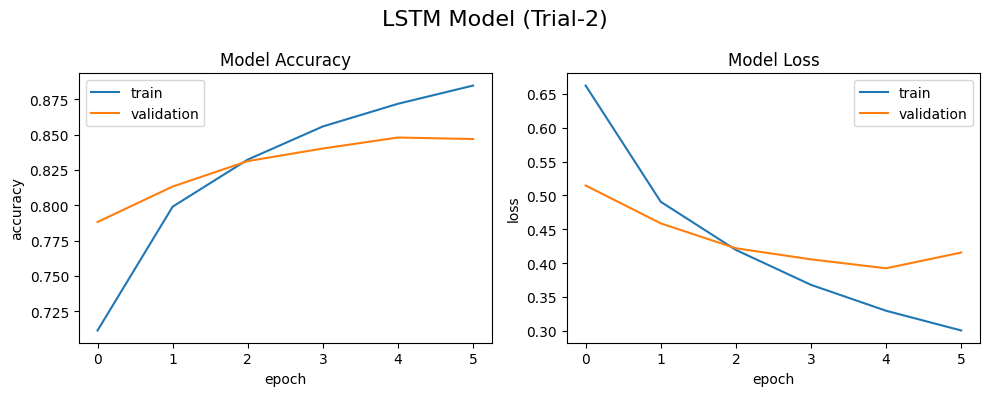

In [ ]:
plotting_model_measurements(lstm_model_trial2_history,'LSTM',2)

In [ ]:
lstm_model_trial2.save('/content/drive/MyDrive/chatbot/saved model/lstm/LSTM_model_trial2_Saved.keras')

In [ ]:
# Trial-3 (embedding_trainable=False)

lstm_model_trial3 = build_LSTM(Conv1D=False , Dense1=True , Dense2=False , lstm_units=128 , _learning_rate=0.001 , embedding_trainable=False , optimizer_type='rmsp' , model_name='LSTM_Trial-3')
lstm_model_trial3_history = lstm_model_trial3.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-3'''
tf.keras.utils.plot_model(lstm_model_trial3, show_shapes=True,to_file="/content/drive/MyDrive/chatbot/images/LSTM Model (Trial 3).png")

lstm_model_trials_dict['Embedding layer Trainable'][2]='No'

Model: "LSTM_Trial-3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,600,000 (36.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,600,000 (36.62 MB)

Epoch 1/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - accuracy: 0.6265 - f1_m: 0.5531 - loss: 0.8229 - precision_m: 0.7080 - recall_m: 0.4635 - val_accuracy: 0.7425 - val_f1_m: 0.7268 - val_loss: 0.6022 - val_precision_m: 0.8000 - val_recall_m: 0.6662
Epoch 2/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 597s 1s/step - accuracy: 0.7320 - f1_m: 0.7159 - loss: 0.6222 - precision_m: 0.7928 - recall_m: 0.6531 - val_accuracy: 0.8010 - val_f1_m: 0.7853 - val_loss: 0.4995 - val_precision_m: 0.8580 - val_recall_m: 0.7242
Epoch 3/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - accuracy: 0.7747 - f1_m: 0.7656 - loss: 0.5364 - precision_m: 0.8211 - recall_m: 0.7175 - val_accuracy: 0.8161 - val_f1_m: 0.8139 - val_loss: 0.4514 - val_precision_m: 0.8385 - val_recall_m: 0.7909
Epoch 4/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 572s 1s/step - accuracy: 0.8028 - f1_m: 0.7968 - loss: 0.4814 - precision_m: 0.8389 - recall_m: 0.7589 - val_accuracy: 0.8393 - val_f1_m: 0.8380 - val_loss: 0.4012 - val_precision_m: 0.8636 - val_recall_m:

In [ ]:
# Trial-3
training_score = lstm_model_trial3.evaluate(X_train, y_train)
testing_score = lstm_model_trial3.evaluate(X_test, y_test)

print(f'\nTrial 3')
print(f'Training Accuaracy (Trial 3): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 3): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 3 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][2]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][2]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 476s 87ms/step - accuracy: 0.8612 - f1_m: 0.8594 - loss: 0.3510 - precision_m: 0.8780 - recall_m: 0.8421
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 117s 85ms/step - accuracy: 0.8420 - f1_m: 0.8410 - loss: 0.4077 - precision_m: 0.8603 - recall_m: 0.8231

Trial 3
Training Accuaracy (Trial 3): 85.8%
Testing Accuaracy (Trial 3): 84.3%


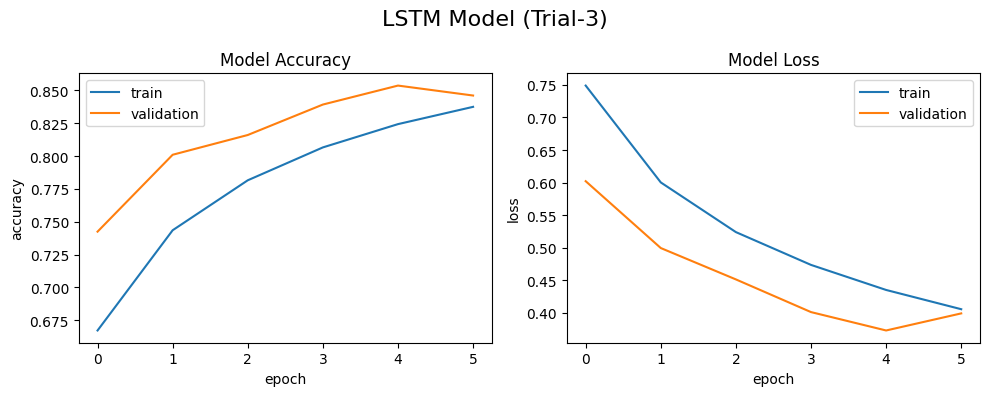

In [ ]:
plotting_model_measurements(lstm_model_trial3_history,'LSTM',3)

In [ ]:
lstm_model_trial3.save('/content/drive/MyDrive/chatbot/saved model/lstm/LSTM_model_trial3_Saved.keras')

In [ ]:
# Trial-4 (embedding_trainable=True)

lstm_model_trial4 = build_LSTM(Conv1D=True , Dense1=True , Dense2=True , lstm_units=128 , _learning_rate=0.001 , embedding_trainable=True , optimizer_type='rmsp' , model_name='LSTM_Trial-4')
lstm_model_trial4_history = lstm_model_trial4.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-4'''
tf.keras.utils.plot_model(lstm_model_trial4, show_shapes=True,to_file="/content/drive/MyDrive/chatbot/images/LSTM Model (Trial 4).png")

lstm_model_trials_dict['Embedding layer Trainable'][3]='Yes'

Model: "LSTM_Trial-4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.6199 - f1_m: 0.5161 - loss: 0.8440 - precision_m: 0.6943 - recall_m: 0.4356 - val_accuracy: 0.8485 - val_f1_m: 0.8465 - val_loss: 0.4171 - val_precision_m: 0.8655 - val_recall_m: 0.8285
Epoch 2/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - accuracy: 0.8687 - f1_m: 0.8662 - loss: 0.3756 - precision_m: 0.8850 - recall_m: 0.8486 - val_accuracy: 0.8927 - val_f1_m: 0.8921 - val_loss: 0.3019 - val_precision_m: 0.9025 - val_recall_m: 0.8820
Epoch 3/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.9091 - f1_m: 0.9078 - loss: 0.2689 - precision_m: 0.9182 - recall_m: 0.8977 - val_accuracy: 0.9115 - val_f1_m: 0.9113 - val_loss: 0.2607 - val_precision_m: 0.9155 - val_recall_m: 0.9071
Epoch 4/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 683s 1s/step - accuracy: 0.9256 - f1_m: 0.9246 - loss: 0.2283 - precision_m: 0.9312 - recall_m: 0.9183 - val_accuracy: 0.9031 - val_f1_m: 0.9035 - val_loss: 0.2799 - val_precision_m: 0.9065 - val_recall_m:

In [ ]:
training_score = lstm_model_trial4.evaluate(X_train, y_train)
testing_score = lstm_model_trial4.evaluate(X_test, y_test)

print(f'\nTrial 4')
print(f'Training Accuaracy (Trial 4): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 4): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 4 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][3]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][3]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 478s 87ms/step - accuracy: 0.9673 - f1_m: 0.9673 - loss: 0.1024 - precision_m: 0.9686 - recall_m: 0.9660
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accuracy: 0.9113 - f1_m: 0.9111 - loss: 0.3009 - precision_m: 0.9125 - recall_m: 0.9099

Trial 4
Training Accuaracy (Trial 4): 95.7%
Testing Accuaracy (Trial 4): 90.9%


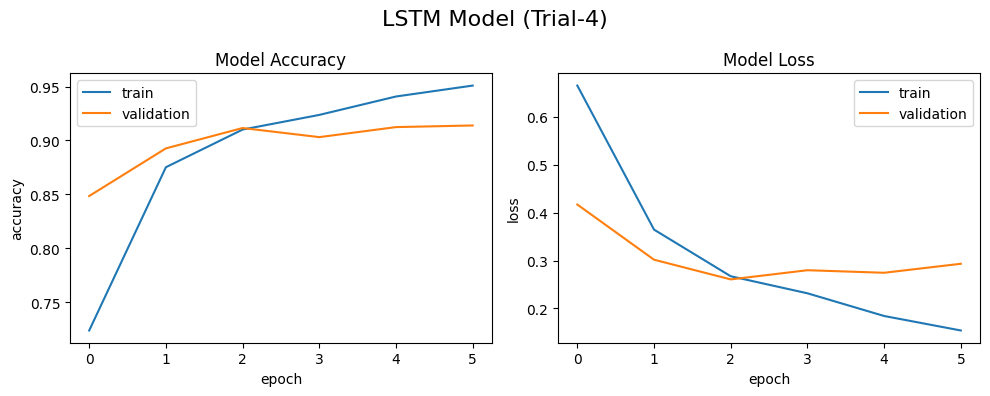

In [ ]:
plotting_model_measurements(lstm_model_trial4_history,'LSTM',4)

In [ ]:
lstm_model_trial4.save('/content/drive/MyDrive/chatbot/saved model/lstm/LSTM_model_trial4_Saved.keras')

In [ ]:
# Trial-5 (embedding_trainable=True)

lstm_model_trial5 = build_LSTM(Conv1D=True , Dense1=True , Dense2=False , lstm_units=256 , _learning_rate=0.001 , embedding_trainable=True , optimizer_type='adam' , model_name='LSTM_Trial-5')
lstm_model_trial5_history = lstm_model_trial5.fit(X_train, y_train,epochs=6, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-5'''
tf.keras.utils.plot_model(lstm_model_trial5, show_shapes=True,to_file="/content/drive/MyDrive/chatbot/images/LSTM Model (Trial 5).png")

lstm_model_trials_dict['Embedding layer Trainable'][4]='Yes'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "LSTM_Trial-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 996s 2s/step - accuracy: 0.7393 - f1_m: 0.6983 - loss: 0.6094 - precision_m: 0.7752 - recall_m: 0.6538 - val_accuracy: 0.9037 - val_f1_m: 0.9015 - val_loss: 0.2738 - val_precision_m: 0.9195 - val_recall_m: 0.8844
Epoch 2/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 999s 2s/step - accuracy: 0.9197 - f1_m: 0.9189 - loss: 0.2380 - precision_m: 0.9247 - recall_m: 0.9133 - val_accuracy: 0.9091 - val_f1_m: 0.9091 - val_loss: 0.2506 - val_precision_m: 0.9135 - val_recall_m: 0.9049
Epoch 3/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 994s 2s/step - accuracy: 0.9466 - f1_m: 0.9464 - loss: 0.1637 - precision_m: 0.9492 - recall_m: 0.9436 - val_accuracy: 0.9101 - val_f1_m: 0.9098 - val_loss: 0.2559 - val_precision_m: 0.9133 - val_recall_m: 0.9064
Epoch 4/6
549/549 ━━━━━━━━━━━━━━━━━━━━ 1047s 2s/step - accuracy: 0.9612 - f1_m: 0.9610 - loss: 0.1211 - precision_m: 0.9633 - recall_m: 0.9588 - val_accuracy: 0.9117 - val_f1_m: 0.9116 - val_loss: 0.2803 - val_precision_m: 0.9136 - val_recall_m

In [ ]:
training_score = lstm_model_trial5.evaluate(X_train, y_train)
testing_score = lstm_model_trial5.evaluate(X_test, y_test)

print(f'\nTrial 5')
print(f'Training Accuaracy (Trial 5): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 5): {round(testing_score[1]*100,1)}%\n\n')

'''   Save the data of trial 5 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][4]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][4]=round(testing_score[1]*100,1)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 496s 90ms/step - accuracy: 0.9865 - f1_m: 0.9866 - loss: 0.0473 - precision_m: 0.9879 - recall_m: 0.9853
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 123s 90ms/step - accuracy: 0.9056 - f1_m: 0.9056 - loss: 0.3201 - precision_m: 0.9081 - recall_m: 0.9031

Trial 5
Training Accuaracy (Trial 5): 97.1%
Testing Accuaracy (Trial 5): 90.5%




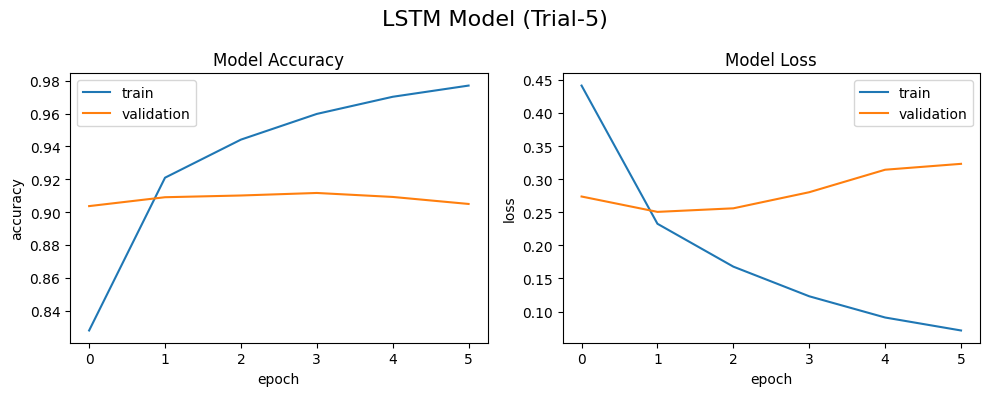

In [ ]:
plotting_model_measurements(lstm_model_trial5_history,'LSTM',5)

In [ ]:
lstm_model_trial5.save('/content/drive/MyDrive/chatbot/saved model/lstm/LSTM_model_trial5_Saved.keras')

In [ ]:
lstm_model_trials_df = pd.DataFrame(lstm_model_trials_dict)
lstm_model_trials_df.to_csv('/content/drive/MyDrive/chatbot/files/LSTM_Trials_Table.csv')
lstm_model_trials_df

,Measurement,Training Accuaracy,Testing Accuaracy,Loss,Embedding layer Trainable
0,Trial-1,0.0,0.0,0,No
1,Trial-2,0.0,0.0,0,No
2,Trial-3,0.0,0.0,0,No
3,Trial-4,0.0,0.0,0,No
4,Trial-5,97.1,90.5,0,Yes


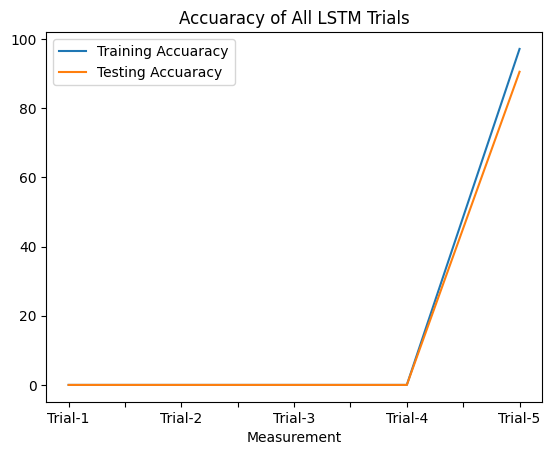

In [ ]:
lstm_model_trials_df[['Measurement','Training Accuaracy','Testing Accuaracy']].plot(x='Measurement', title = 'Accuaracy of All LSTM Trials');
plt.savefig('/content/drive/MyDrive/chatbot/images/LSTM Model (All Trials Accuracies).png')

# **We Notice that the high accuracy for the 2 models after training them is:-**


*   CNN Model => Trial 4
*   LSTM Model => Trial 5



# **New tweets Predictions**
**Labels**


*   Negative => 0
*   Positive => 1
*   Neutral => 2





In [ ]:
def sentiment_category(label_id):
    label = ''
    if label_id==1:
        label = 'positive'
    elif label_id==2:
        label = 'neutral'
    else:
        label = 'negative'
    return label

# **Using CNN Model**

In [ ]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/chatbot/saved model/cnn/CNN_model_trial4_Saved.keras',
                                              custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m })
cnn_model.summary()

Model: "CNN_Trial-4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ (None, 49, 300)             │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 49, 128)             │         614,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 16, 128)             │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 5, 128)              │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,248,523 (123.02 MB)

 Trainable params: 10,749,507 (41.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,499,016 (82.01 MB)

In [ ]:
# Postive Example
tweet = "High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports"  # positive

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
# Lemmatize each word individually within the list
new_tweet = [lemmatizer.lemmatize(word) for word in new_tweet] # Iterate through the list of words and lemmatize them one by one
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {tweet}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n') # Changed 'text' to 'tweet'



# Negative Example
tweet = "Sooo SAD I will miss you here in San Diego"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
# Lemmatize each word individually within the list
new_tweet = [lemmatizer.lemmatize(word) for word in new_tweet] # Iterate through the list of words and lemmatize them one by one
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {tweet}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n') # Changed 'text' to 'tweet'



# Negative Example
tweet = " My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
# Lemmatize each word individually within the list
new_tweet = [lemmatizer.lemmatize(word) for word in new_tweet] # Iterate through the list of words and lemmatize them one by one
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {tweet}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n') # Changed 'text' to 'tweet'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Text: High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports
Label ID: 1
Label Name: positive
Polarity: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Text: Sooo SAD I will miss you here in San Diego
Label ID: 0
Label Name: negative
Polarity: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Text:  My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!
Label ID: 1
Label Name: positive
Polarity: 1.0




# **Using LSTM Model**

In [ ]:
lstm_model = tf.keras.models.load_model('/content/drive/MyDrive/chatbot/saved model/lstm/LSTM_model_trial5_Saved.keras',
                                              custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m })
lstm_model.summary()

Model: "LSTM_Trial-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_Layer (Embedding)          │ (None, 49, 300)             │       9,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 42, 64)              │         153,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 512)                 │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,629,515 (120.66 MB)

 Trainable params: 10,543,171 (40.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,086,344 (80.44 MB)

In [ ]:
# Postive Example
tweet = "High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports"  # positive

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
# Lemmatize each word individually within the list
new_tweet = [lemmatizer.lemmatize(word) for word in new_tweet] # Iterate through the list of words and lemmatize them one by one
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = lstm_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {tweet}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# Negative Example
tweet = "Sooo SAD I will miss you here in San Diego"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
# Lemmatize each word individually within the list
new_tweet = [lemmatizer.lemmatize(word) for word in new_tweet]# Iterate through the list of words and lemmatize them one by one
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = lstm_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {tweet}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# neutral Example
tweet = " My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!"  # neutral

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
# Lemmatize each word individually within the list
new_tweet = [lemmatizer.lemmatize(word) for word in new_tweet] # Iterate through the list of words and lemmatize them one by one
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = lstm_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {tweet}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Text: High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports
Label ID: 1
Label Name: positive
Polarity: 0.9997361302375793


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Text: Sooo SAD I will miss you here in San Diego
Label ID: 0
Label Name: negative
Polarity: 0.9999303817749023


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Text:  My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!
Label ID: 1
Label Name: positive
Polarity: 0.9993277788162231


